In [22]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
import scipy
import scipy.io as sio

In [24]:
wavelet_challenge = sio.loadmat('wavelet_codeChallenge.mat')
wavelet_challenge

original = np.squeeze(wavelet_challenge['signal'])
signalFIR = np.squeeze(wavelet_challenge['signalFIR'])
signalMW = np.squeeze(wavelet_challenge['signalMW'])
srate = wavelet_challenge['srate'][0][0]

npnts = len(original)

[]

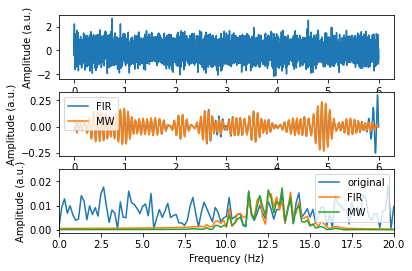

In [26]:
# Plot in time domain and frequency domain

time_vec = np.arange(0, npnts)/srate
hz_vec = np.linspace(0, srate, npnts)

# Get amplitude spectra
amp_original = np.abs(scipy.fft.fft(original)/npnts)
amp_signalFIR = np.abs(scipy.fft.fft(signalFIR)/npnts)
amp_signalMW = np.abs(scipy.fft.fft(signalMW)/npnts)

plt.figure()
plt.subplot(311)
plt.plot(time_vec, original, label='original')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')

plt.subplot(312)
plt.plot(time_vec, signalFIR, label='FIR')
plt.plot(time_vec, signalMW, label='MW')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.legend()

plt.subplot(313)
plt.plot(hz_vec, amp_original, label='original')
plt.plot(hz_vec, amp_signalFIR, label='FIR')
plt.plot(hz_vec, amp_signalMW, label='MW')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (a.u.)')
plt.xlim([0,20])
plt.legend()

plt.plot(hspace = 1)



In [ ]:
# 2-stage wideband filter? 
# Refresh memory on how to do this 
